In [3]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

from scipy import ndimage

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [4]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
# train_mask_crops = data_dir/"mask_crops"
train_mask_crops = data_dir/"mask_crops_single_channel"
label_dir = data_dir/"train"/"labels"

In [3]:
def create_mask(json_file, data_dir, mask_dir, tile_size=1024):
    with open(data_dir/"train"/"labels"/json_file, 'r') as f:
        label = json.load(f)
    label_gdf = parse_json(label)
    if label_gdf is None or len(label_gdf) == 0:
        return
    fb_mask = sol.vector.mask.df_to_px_mask(df=label_gdf, geom_col="geometry_pixel",
                                         channels=['footprint'],
                                         shape=(tile_size,tile_size)).squeeze()
    # print(fb_mask.shape)
    PIL.Image.fromarray(fb_mask, mode='L').save(mask_dir/(json_file.replace('.json', '.png')))

In [4]:
pre_images = [x for x in mask_dir.ls() if 'pre_' in x.name]
pre_images[10]

PosixPath('/media/wwymak/Storage/xView2/mask_full_size/hurricane-harvey_00000022_pre_disaster.png')

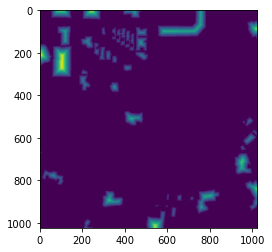

In [13]:
sample_mask = np.array(PIL.Image.open(pre_images[10]))[:,:,0] /255
inverted_sample_mask = 1 - sample_mask
transformed = ndimage.distance_transform_edt(sample_mask)
trasformed_inverted = ndimage.distance_transform_edt(inverted_sample_mask) * -1
plt.imshow(transformed / transformed.max() * 255)

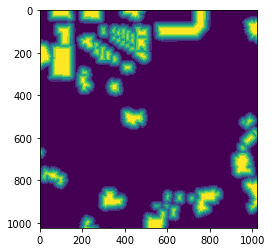

In [31]:
combined = transformed + trasformed_inverted

bins =np.arange(-20, 20, 5)
combined_binned = np.digitize(combined, bins, right=False)
plt.imshow(combined_binned / combined_binned.max() * 255)


In [32]:
np.unique(combined_binned)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [24]:
trasformed_inverted_binned.shape

(1024, 1024)

8 0 [0 1 2 3 4 5 6 7 8]


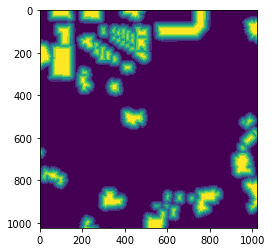

In [7]:
# run create_edt_mask.py
# sanity check:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir_edt = data_dir /"mask_full_size_edt"
sample_file = mask_dir_edt.ls()[10]

img = np.array(PIL.Image.open(sample_file))
plt.imshow(img)

print(img.max(), img.min(), np.unique(img))